# Phase 4: Deep Learning Model (Neural Networks)
**Project:** News Document Classification System  
**Goal:** Transition from frequency-based features (TF-IDF) to sequence-based modeling using Word Embeddings and Neural Networks.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


import random

# Set the seed for reproducibility
seed_value = 90
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [49]:
# Set visual style
sns.set_theme(style="whitegrid")

## 1 Loading Processed Data
Importing the cleaned training and testing sets generated in Phase 1 to ensure consistency across all modeling experiments.

In [50]:
# Load the cleaned data from Phase 1
train_path = '../data/processed/news_clean_train.csv'
test_path = '../data/processed/news_clean_test.csv'

df_train = pd.read_csv(train_path).dropna()
df_test = pd.read_csv(test_path).dropna()

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (120000, 2)
Test shape: (7600, 2)


In [51]:
# Define label mapping for reference
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

## 2 Tokenization & Padding
Text is converted into numerical sequences using a vocabulary-limited tokenizer and padded to a uniform length of 70 tokens to prepare it for neural network input.

In [52]:
# Configuration
MAX_WORDS = 10000  # Only keep the top 10k most frequent words
MAX_LEN = 70      # Based on EDA, 70 words covers most descriptions
EMBEDDING_DIM = 64

# 1. Initialize Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_text'])

# 2. Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(df_train['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['cleaned_text'])

# 3. Pad sequences to ensure uniform input length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

y_train = df_train['label'].values
y_test = df_test['label'].values

print(f"Sample sequence: {X_train_seq[0][:10]}...")
print(f"Padded shape: {X_train_pad.shape}")

Sample sequence: [351, 1, 7759, 666, 92, 606, 3751, 351, 255, 5929]...
Padded shape: (120000, 70)


In [53]:
# We must save the tokenizer to use it later in our Streamlit app
os.makedirs('../models', exist_ok=True)
with open('../models/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved to models/tokenizer.pkl")

Tokenizer saved to models/tokenizer.pkl


## 3 Building the Neural Network Architecture
Designing a Sequential model featuring an Embedding layer for semantic representation and Global Average Pooling to reduce dimensionality before classification.

In [54]:
from tensorflow.keras.layers import Input # Add this import

model = Sequential([
    ## This explicitly defines the input shape so the model builds immediately
    Input(shape=(MAX_LEN,)),
     
     # Layer 1: Word Embeddings
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM),    
    # Layer 2: Dimensionality Reduction
    GlobalAveragePooling1D(),
    
    # Layer 3: Hidden Dense Layer
    Dense(64, activation='relu'),
    Dropout(0.3), # Regularization to prevent overfitting
    
    # Layer 4: Output Layer (4 classes)
    Dense(4, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 70, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,420 (2.46 MB)

 Trainable params: 644,420 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

## 4 Training the Model
The model is trained using the Adam optimizer and Sparse Categorical Crossentropy, with Early Stopping implemented to restore the best weights and mitigate overfitting.

In [55]:
# Use EarlyStopping to stop training if validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    validation_split=0.1,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.8558 - loss: 0.4300 - val_accuracy: 0.9071 - val_loss: 0.2605
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.9146 - loss: 0.2597 - val_accuracy: 0.9097 - val_loss: 0.2536
Epoch 3/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.9241 - loss: 0.2290 - val_accuracy: 0.9068 - val_loss: 0.2610
Epoch 4/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.9301 - loss: 0.2068 - val_accuracy: 0.9066 - val_loss: 0.2668


## 5 Evaluation & Visualization
Performance is assessed through accuracy and loss curves to visualize the learning rate and identify the divergence between training and validation sets.

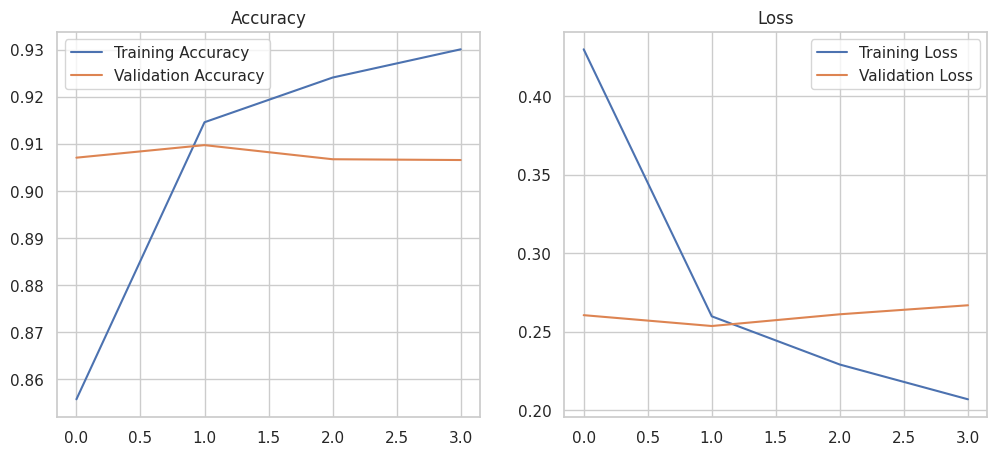

In [56]:
# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

### Model Performance & Overfitting Analysis

**Observation:**
The training logs indicate that the model began to **overfit** after **Epoch 2**. 
* **Evidence:** The validation loss reached its minimum at **0.2536 (Epoch 2)** before trending upward in subsequent epochs. This "V-shape" in the validation loss confirms that the model started memorizing the training noise rather than learning general patterns.
* **Accuracy Gap:** By Epoch 4, the training accuracy reached 93.01%, while validation accuracy plateaued and slightly declined to 90.66%, a gap of roughly 2.35%.

**Mitigation Strategy Applied:**
1. **Early Stopping:** The `EarlyStopping` callback was utilized with `restore_best_weights=True`. 
2. **Result:** Although training proceeded until Epoch 4, the optimized weights from **Epoch 2** were restored for the final saved model (`nn_model.h5`).

**Verdict:** Even with the early onset of overfitting, the model achieves a reliable performance that consistently outperforms the 90.39% Logistic Regression baseline.

In [57]:
# Final Test Accuracy
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.9101


## 6 Comparison with Phase 2
We compare our Deep Learning results against the 90.39% Logistic Regression baseline to justify the added complexity of the neural network.

In [58]:
# Based on previous work: Logistic Regression Accuracy was ~90.39%
results = {
    "Model": ["Logistic Regression (Baseline)", "Neural Network (MLP)"],
    "Accuracy": [0.9039, test_acc]
}

df_results = pd.DataFrame(results)
print(df_results)

                            Model  Accuracy
0  Logistic Regression (Baseline)  0.903900
1            Neural Network (MLP)  0.910132


In [59]:
# Save the final DL model
model.save('../models/nn_model.h5')
print("\nDeep Learning model saved to models/nn_model.h5")


Deep Learning model saved to models/nn_model.h5


## 7 Quick Inference Test
A final sanity check is performed on unseen sample sentences to verify that the saved model and tokenizer handle raw text predictions correctly.

In [60]:
def predict_category(text):
    # Preprocess (simplistic version, for full pipeline use inference.py later)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LEN)
    pred = model.predict(padded, verbose=0)
    return label_map[np.argmax(pred)]

# Test Cases
samples = [
    "The tech giant released a new smartphone with AI features.",
    "The football world cup final was a thrilling match.",
    "Stock markets crashed after the latest inflation report."
]

for s in samples:
    print(f"Text: {s} \nPredicted: {predict_category(s)}\n")

Text: The tech giant released a new smartphone with AI features. 
Predicted: Sci/Tech

Text: The football world cup final was a thrilling match. 
Predicted: Sports

Text: Stock markets crashed after the latest inflation report. 
Predicted: Business



## 8 Summary & Next Steps

**Conclusion:**
Transitioning from statistical machine learning to deep learning enabled the capture of complex semantic relationships through word embeddings. The final architecture achieved a test accuracy of 91.01%. While a divergence between training and validation loss was noted, the implementation of EarlyStopping ensured the retention of optimized model weights.

**Next Phase:**
The project enters **Production-Grade Inference Layer.** The focus shifts from experimental notebooks to the development of a standalone Python script (inference.py) to handle real-time predictions in a production environment.